In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
def load_preproccess_scale_transform(csv_filepath):
    COLUMN_ORDER = [
        "SM_4",
        "Time",
        "ST_4",
        "temp",
        "humidity",
        "precip",
        "windspeed",
        "cloudcover",
        "conditions",
    ]

    dataset = pd.read_csv(csv_filepath)

    dataset.drop(
        [
            "Date",
            "SM_2",
            "SM_8",
            "SM_20",
            "SM_40",
            "ST_2",
            "ST_8",
            "ST_20",
            "ST_40",
            "solarenergy",
            "precipprob",
            "preciptype",
            "snow",
            "snowdepth",
            "windgust",
            "winddir",
            "sealevelpressure",
            "visibility",
            "solarenergy",
            "uvindex",
            "severerisk",
            "icon",
            "stations",
            "dew",
            "solarradiation",
            "Time",
            # "cloudcover",
            "feelslike",
            # "windspeed",
        ],
        inplace=True,
        axis=1,
    )

    dataset.dropna(inplace=True)
    # dataset = dataset[COLUMN_ORDER]
    # dataset["Time"] = dataset["Time"].apply(lambda x: int(x[:2]))

    X = dataset.iloc[:, 1:].values
    # print(X[0])

    y = dataset.iloc[:, 0].values

    ct = ColumnTransformer(
        transformers=[("encoder", OneHotEncoder(), [-1])], remainder="passthrough"
    )

    X = np.array(ct.fit_transform(X))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    sc = MinMaxScaler()

    X_train[:, 9:] = sc.fit_transform(X_train[:, 9:])

    X_test[:, 9:] = sc.transform(X_test[:, 9:])

    X_train, y_train, X_test, y_test = map(
        np.asarray, [X_train, y_train, X_test, y_test]
    )

    X_train, X_test = map(lambda x: x.astype("float32"), [X_train, X_test])

    return (X_train, y_train), (X_test, y_test)

In [4]:
(X_train, y_train), (X_test, y_test) = load_preproccess_scale_transform(
    "storage_dataset/prototype_final_dataset.csv"
)

[0 15.5 21.6 84.5 0.0 22.3 100.0 'Overcast']

Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 773.5737 - mean_absolute_error: 26.3858 - val_loss: 71.6892 - val_mean_absolute_error: 7.1187
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 40.2554 - mean_absolute_error: 5.3531 - val_loss: 30.6217 - val_mean_absolute_error: 4.7182
Epoch 3/100
188/188 [==============================] - 0s 1ms/step - loss: 21.6532 - mean_absolute_error: 3.8752 - val_loss: 18.2831 - val_mean_absolute_error: 3.5262
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 16.5237 - mean_absolute_error: 3.3240 - val_loss: 16.1957 - val_mean_absolute_error: 3.2838
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 15.2172 - mean_absolute_error: 3.1786 - val_loss: 15.2804 - val_mean_absolute_error: 3.1913
Epoch 6/100
188/188 [==============================] - 0s 1ms/step - loss: 14.5968 - mean_absolute_error: 3.1092 - val_loss: 14.5188 - val_mean_absolute_error: 3.1

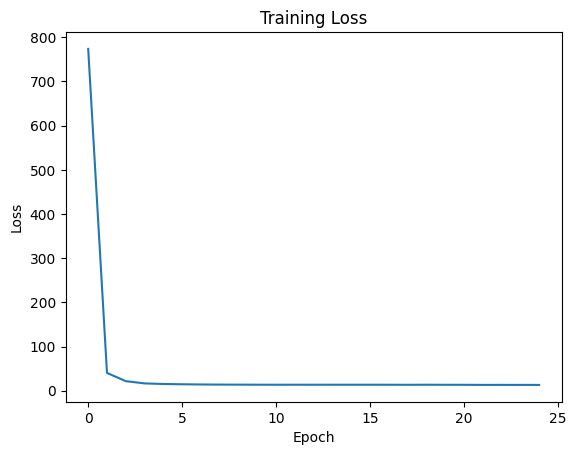

In [12]:
""" Model """
ANN_model = keras.Sequential(
    [
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(4, activation="relu"),
        keras.layers.Dense(2, activation="relu"),
        keras.layers.Dense(1),
    ]
)

ANN_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.mean_squared_error,
    metrics=keras.metrics.mean_absolute_error,
)
early_stopping = EarlyStopping(patience=5)
history = ANN_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

ANN_model.summary()

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [6]:
ann_ypred = ANN_model.predict(X_test)

63/63 [==============================] - 0s 678us/step


In [7]:
from sklearn.tree import DecisionTreeRegressor

# Increase maximum depth
dtr_model = DecisionTreeRegressor(
    max_depth=10, random_state=0, min_samples_split=20)

# Fine-tune hyperparameters
dtr_model.fit(X_train, y_train)

dtr_ypred = dtr_model.predict(X_test).reshape(-1, 1)

dtr_mae = mean_absolute_error(y_test, dtr_ypred)
dtr_mse = mean_squared_error(y_test, dtr_ypred)
print("DTR MAE:", dtr_mae)
print("DTR MSE:", dtr_mse)

DTR MAE: 2.456333668793948
DTR MSE: 11.338114426008651


In [8]:
from sklearn.svm import SVR

# Try different kernels
svr_models = [
    SVR(kernel="rbf", C=10, gamma=0.1),
    SVR(kernel="linear", C=10),
    SVR(kernel="poly", C=10, degree=3),
]

# Fine-tune hyperparameters
for model in svr_models:
    model.fit(X_train, y_train)

    svr_ypred = model.predict(X_test)

    svr_mae = mean_absolute_error(y_test, svr_ypred)
    svr_mse = mean_squared_error(y_test, svr_ypred)

    print(f"SVR {model.kernel} MAE: {svr_mae}, MSE: {svr_mse}")

SVR rbf MAE: 2.9110177952651224, MSE: 13.56129598788233
SVR linear MAE: 3.020224160252679, MSE: 14.04643001591145
SVR poly MAE: 2.838411790821146, MSE: 13.372517516552076


In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Feature selection using L1 regularization
mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

mlr_ypred = mlr_model.predict(X_test)

mlr_mae = mean_absolute_error(y_test, mlr_ypred)
mlr_mse = mean_squared_error(y_test, mlr_ypred)
print("MLR MAE:", mlr_mae)
print("MLR MSE:", mlr_mse)

# Consider adding polynomial features

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

mlr_model_poly = LinearRegression()
mlr_model_poly.fit(X_train_poly, y_train)

mlr_poly_ypred = mlr_model_poly.predict(X_test_poly)

mlr_poly_mae = mean_absolute_error(y_test, mlr_poly_ypred)
mlr_poly_mse = mean_squared_error(y_test, mlr_poly_ypred)
print("MLR with Poly Features MAE:", mlr_poly_mae)
print("MLR with Poly Features MSE:", mlr_poly_mse)

MLR MAE: 3.0356934568363276
MLR MSE: 13.957228923500654
MLR with Poly Features MAE: 2.990608626497006
MLR with Poly Features MSE: 13.586597246790598


Text(0.5, 1.0, 'mlr_model')

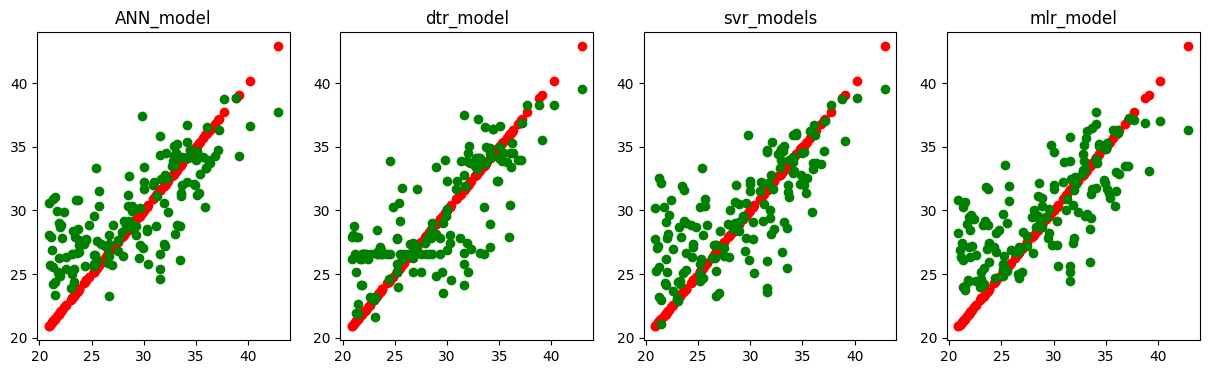

In [17]:
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], ann_ypred[:150], color="green")
plt.title("ANN_model")

plt.subplot(142)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], dtr_ypred[:150], color="green")
plt.title("dtr_model")

plt.subplot(143)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], svr_ypred[:150], color="green")
plt.title("svr_models")

plt.subplot(144)
plt.scatter(y_test[:150], y_test[:150], color="red")
plt.scatter(y_test[:150], mlr_ypred[:150], color="green")
plt.title("mlr_model")